# Simplicial Complex in Three Dimensions

We dsecribe the data structure of the simplicial complex associated to a three dimensional trianglulation give by `node,elem` . The `node` records
the coordinates of vertices and `elem` is the pointer from local to
global incices of vertices. See [Basic mesh data structure](meshbasicdoc.html).

A brief summary.
- `edge`: asecond ordering, i.e. `edge(:,1)<edge(:,2)`

- `face`: asecond ordering, i.e. `face(:,1)<face(:,2)<face(:,3)`

- `elem`: either the positive ordering or the ascend ordering. The default one is the positive ordering and the asecond ordering is mainly used for edge and face elements. 

- Use `[elem,bdFlag] = sortelem3(elem,bdFlag)` to change the ordering to the ascend ordering. Note that `bdFlag` should be switched together. 

> The multigrid solvers use the original ordering of `elem` obtained from either uniform refinement or bisection methods. So let `elemold=elem` before sort.

- Examples on the usage: `Poisson3RT0; Maxwell; Maxwell2;`

## Outline

The basic data structure of a mesh consists of `node` and `elem`. The corresponding simplicial complex consists of vertices, edges, faces, and tetrahedron. We shall discuss three issues 

- *Indexing* of simplexes
- *Ordering* of vertices
- *Orientation* of simplexes

The indexing and ordering are related and the ordering and orientation
are mixed together. However the indexing has nothing to do with the
orientation. The indexing and ordering are the combinarotry structure,
i.e. only `elem` is needed, while the orientation also depends on `node`,
the geometry emembdding of vertices.

For indexing, ordering and orientation, there are always local and global versions. The relation between the local and global version is the most complicated issue.

## Indexing of Simplexes

The indexing refers to the numbering of simplexes, e.g., which face is
numbered as the first one. There are two types of the indexing: local and
global. Each simplex in the simplicial complex has a unique index which
is called the global index. In one tetrahedra, the four vertices and four
faces have their local index from 1:4. 

In the assembling procedure of finite element methods, an element-wise
matrix using the local indexing is first computed and then assembled to get a
big matrix using the global indexing. Thus the pointer from the local
indexing to the global indexing is indispensible. For bases independent of
the ordering and orientation, e.g., `P1` and `P2` elements, this pointer
is sufficient, otherwise, the inconsistency of the local ordering/orientation
and the global ordering/orientation should be taken into account.

### Local indexing

The tetrahedron consists of four vertices indexed as [1 2 3 4]. Each
tetrahedron contains four faces and six edges. They can be indexed as

    locFace = [2 3 4; 1 3 4; 1 2 4; 1 2 3];
    locEdge = [1 2; 1 3; 1 4; 2 3; 2 4; 3 4];

In `locFace`, the i-th face is opposite to the i-th vertices and thus
this is called _opposite indexing_. In `locEdge`, it is the
_lexicographic indexing_ which is induced from the lexicographic ordering
of the six edges. The ordering of vertices of each face or edge will not
change the indexing. For example, the following `locFacec` and `locEdged`
has the same indexing as `locFace` and `locEdge` but a different ordering
of vertices.

    locFacec = [2 3 4; 1 4 3; 1 2 4; 1 3 2];
    locEdge = [2 1; 3 1; 4 1; 3 2; 4 2; 4 3];

Indeed any permuation of each simplex will represent the same simplex and
will not change the indexing. The ordering of vertices will affect the
orientation and will be discussed later.

For a face consists of three vertices [1 2 3], there are two indexing
schemes of its three edges.

- Oppoiste indexing:        `[2 3; 3 1; 1 2]`
- Lexicographic indexing:   `[1 2; 1 3; 2 3]`

Each indexing scheme has its advantange and disadavantange and which one
to chose depends on the consideration of ordering and orientation.

### Global indexing and vertex pointers

Each simplex in the simplicial complex has a unqiue index. It is
represented by vertices pointer from the local index to the globa index
of vertices.

The matrix `elem` is the pointer from local to global indices of vertices
of tetrahedron, e.g. `elem(t,1)=25` means the first vertex of the
tetrahedron t is the 25-th vertex.

Similarly the `NE x 2` matrix `edge` records all edges and the `NF x 3` by 3
matrix `face` records all faces of the triangulation. These are vertices
pointers. We shall discuss the elementwise pointer from the local indices to
the global indices for edges and faces.



elem =

     1     2     3     7
     1     4     3     7
     1     5     6     7
     1     5     8     7
     1     2     6     7
     1     4     8     7



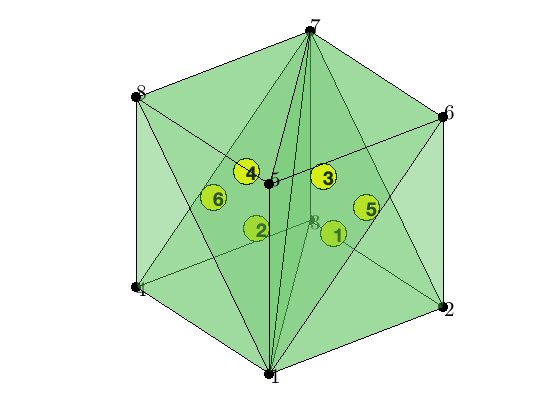

In [16]:
[node,elem] = cubemesh([-1,1,-1,1,-1,1],2);
showmesh3(node,elem,[],'FaceAlpha',0.25);
findelem3(node,elem);
findnode3(node,elem(:));
display(elem);

### Generate index pointers for edges and faces

One can easily collect edges and faces elementwise. The issue is the
duplication. For example, each interior face will be counted twice. The
`unique` function is applied such that each edge or face has a unique
global index.

**Edge and Face**

In [17]:
totalEdge = uint32([elem(:,[1 2]); elem(:,[1 3]); elem(:,[1 4]); ...
                    elem(:,[2 3]); elem(:,[2 4]); elem(:,[3 4])]);
sortedTotalEdge = sort(totalEdge,2);
[edge, ~, je] = unique(sortedTotalEdge,'rows');
display(edge);

totalFace = uint32([elem(:,[2 3 4]); elem(:,[1 4 3]); ...
                    elem(:,[1 2 4]); elem(:,[1 3 2])]);
sortedTotalFace = sort(totalFace,2);                
[face, i2, jf] = unique(sortedTotalFace,'rows');
display(face);


edge =

  19�2 uint32 matrix

   1   2
   1   3
   1   4
   1   5
   1   6
   1   7
   1   8
   2   3
   2   6
   2   7
   3   4
   3   7
   4   7
   4   8
   5   6
   5   7
   5   8
   6   7
   7   8


face =

  18�3 uint32 matrix

   1   2   3
   1   2   6
   1   2   7
   1   3   4
   1   3   7
   1   4   7
   1   4   8
   1   5   6
   1   5   7
   1   5   8
   1   6   7
   1   7   8
   2   3   7
   2   6   7
   3   4   7
   4   7   8
   5   6   7
   5   7   8



In iFEM, `N,NE,NF,NT` represents the number of vertices, edges, faces and tetrahedrons, resprectively.

    N = size(node,1); NT = size(elem,1); NF = size(face,1); NE = size(edge,1);

In the assembling procedure, the matrix is always computed elementwise and then assemble to a big one. A pointer from the local index of a simplex to its global index is thus indispensible.

**Elementwise pointers**

- `elem2node = elem`
- `elem2face(1:NT, 1:4)`
- `elem2edge(1:NT, 1:6)`

Such information is exactly stored in the output of `unique` function. For example, `elem2face(t,1) = 17` means the first face of t (spanned by `[2 3 4]`) is the 17-th element in the `face` matrix. 

In [18]:
N = size(node,1); NT = size(elem,1); NF = size(face,1); NE = size(edge,1);
elem2edge = uint32(reshape(je,NT,6));
elem2face = uint32(reshape(jf,NT,4));
display(elem2edge);
display(elem2face);


elem2edge =

  6�6 uint32 matrix

    1    2    6    8   10   12
    3    2    6   11   13   12
    4    5    6   15   16   18
    4    7    6   17   16   19
    1    5    6    9   10   18
    3    7    6   14   13   19


elem2face =

  6�4 uint32 matrix

   13    5    3    1
   15    5    6    4
   17   11    9    8
   18   12    9   10
   14   11    3    2
   16   12    6    7



**Face to edge Pointer**

`face2edge(1:NF,1:3)` records the global indices of three edges of a
face. This pointer depends on the ordering of vertices of faces and the
indexing of local edges in a face. We list the following two important
cases. Other combinations is possible but not attractive.

- Ascend ordering.

All local faces and local edges are ascend ordered.
    
    locFace = [2 3 4; 1 3 4; 1 2 4; 1 2 3];
    locEdge = [1 2; 1 3; 1 4; 2 3; 2 4; 3 4];
    edgeOfFace = [1 2; 1 3; 2 3];
    locFace2edge = [4 5 6; 2 3 6; 1 3 5; 1 2 4];

- Consistent ordering

The local face is ordered such that the corresponding orientation is
consistent with the induced orientation.

    locFace = [2 3 4; 1 4 3; 1 2 4; 1 3 2];
    locEdge = [1 2; 1 3; 1 4; 2 3; 2 4; 3 4];
    edgeOfFace = [2 3; 3 1; 1 2];   
    locFace2edge = [6 5 4; 6 2 3; 5 3 1; 4 1 2];

The global one can be obtained from the composition of `elem2face` and
`locFace2edge`. For example, for the asecnd ordering scheme,

    face2edge(elem2face(:,1),:) = elem2edge(:,[4 5 6]);
    face2edge(elem2face(:,2),:) = elem2edge(:,[2 3 6]);
    face2edge(elem2face(:,3),:) = elem2edge(:,[1 3 5]);
    face2edge(elem2face(:,4),:) = elem2edge(:,[1 2 4]);

## Ordering of Vertices

We discuss the ordering of vertices of simplexes. Again there are local
ordering and global ordering. They may not be consistent and a sign array
is used to record the inconsistency if any.

The local ordering refers to the ordering of vertices in `locFace` or
`locEdge`, i.e. the ordering of the local index of vertices. For elements
associated to faces or edges, the local ordering could be used in the
formulation of the local basis and thus the ordering does matter.

The global ordering refers to the ordering of vertices in `face` or
`edge`, i.e., the ordering of the global index of vertices. Note that
that in either local or global ordering, permutation of vertices will
represent the same simplex. To fix an ordering we need extra information.

### elem
The local ordering is always [1 2 3 4]. Any permutation of four vertices of a tetrahedon still represents the same tetrahedron. Such freedom provide a room to record more information like:

* global ordering of vertices
* an orientation of element
* refinement rules (uniform refinement or bisection)

For 2-D triangulations, three vertices of a triangle in 2-D is sorted counter-cloclwise and the first vertex is chosen as the newest vertex. Such ordering enables the efficient implementation of local refinement
and coarsening in 2-D; see [Bisection in Two Dimensions](../afem/bisectdoc.html)
and [Coarsening in Two Dimensions](../afem/coarsendoc.html).

In 3-D, for the longest edge bisection, the newest vertex (with the highest generation) is stored as the last (4-th) vertex of a tetrahedron. For [3-D Red Refinement](uniformrefine3doc.html), the ordering determines the shape regularity of refined triangulation. Permuation of vertices in `elem` could deterioriate the angle condition after the refinement.

We shall reserve the ordering of `elem` from the mesh refinement and
coarsening since they are more subtle. We switch the ordering when
generating data structure for finite element basis and assemble the
matrix equation. Such sorting is hidden in the subroutines when a finite
element basis requiring ordering is generated.

Two types of ordering of `elem` is of particular importantance
- Ascend ordering
- Positive ordering

In the ascend ordering, the vertices of `elem` is sorted such that 

    elem(t,1) < elem(t,2) < elem(t,3) < elem(t,4). 
    
Such ordering will benefit the construction of local bases for high order basis or basis with orientation. This can be easily achieved by `elem = sort(elem,2)`. One has to rotate the boundary flag accordingly.

In [22]:
bdFlag = setboundary3(node,elem,'Dirichlet');
[elem,bdFlag] = sortelem3(elem,bdFlag);    
display(elem);


elem =

     1     2     3     7
     1     3     4     7
     1     5     6     7
     1     5     7     8
     1     2     6     7
     1     4     7     8



In the positive ordering, the four vertices are ordered such that the
signed volume, the mix product of vectors (v12,v13,v14), is positive.
This is the default ordering used so far. `fixorder3` will switch the
vertices for elements with negative volume. 

In [25]:
elem = fixorder3(node,elem)   % switchs the vertices for elements with negative volume.


elem =

     1     2     3     7
     1     3     4     7
     1     5     6     7
     1     5     7     8
     1     6     2     7
     1     7     4     8



### edge

For 3-D triangulations, we chose the ascend ordering both locally and globally. Namely

    locEdge(:,1) < locEdge(:,2); 
       edge(:,1) < edge(:,2);

Recall that for `locEdge = [1 2; 1 3; 1 4; 2 3; 2 4; 3 4]`, it is ascend
ordered. The `edge` produced by `unique` function is also ascend
ordered. 

There might be inconsistency between the local and global ordering.
That is `edge(elem2edge(t,1),1)` may not be smaller than `edge(elem2edge(t,1),2)`. It will be more clear from the discussion of the corresponding orientation.

For 2-D triangulations, the global ordering is still ascend ordered. But locally it may not. For example, for the consisitent ordering `locEdge = [2 3; 3 1; 1 2]`, then `locEdge(2,1) > locEdge(2,2)`.

### face

For 3-D triangulations, the `face` produced by `unique` function is already sorted in the second dimension such that the global ordering is ascended i.e. `face(:,1) < face(:,2) < face(:,3)`. The local ordering in `locFace`, however, is not always ascend ordered.

    locFace = [2 3 4; 1 3 4; 1 2 4; 1 2 3]; % Ascend ordering
    locFace = [2 3 4; 1 4 3; 1 2 4; 1 3 2]; % Consistent ordering

Again the local and the global ordering maynot be consisitent. That is

    face(elem2face(t,:),1) < face(elem2face(t,:),2) < face(elem2face(t,:),3)
    
maynot be always true unless we use the ascend ordering in both `face` and `locFace`.

## Orientation

The orientation of a tetrahedron is either positive or negative. The
orientation of a face is given by a normal vector and the orientation of
an edge is determined by a tangential vector. 

The orientation of a d-simplex will induce an orientation of its d-1 boundary
subcomplex and is called the *induced orientation*. For example, a positive
orientated tetrahedron will induce the outwards normal orientation of its
four faces and a positive orientated triangle will induce the counter
clockwise orientation of its three edges.

The ordering of vertices of a simplex will naturally introduce an
orientation and will be called the *ordering orientation*. More specifically

- the vector from `edge(:,1)` to `edge(:,2)` defines an orientation of edges.
- the `cross(v12,v13)` defines an orientation of a face, where `vij` is
the vector from vertex `face(:,i)` to `face(:,j)`.
- the sign of the mix product `sign(v12, v13, v14)` defines an orientation for tetrahedrons.

The orientation of a simplex in the simplicial complex should be uniquely
determined which will be called the *global orientation*. It can be chosen as
the global ordering orientation but not always.

Inside one tetrahedron, the local ordering of local edges and local faces
will introduce a corresponding orientation. The orientation of the
tetrahedron will also induce an orientation for its four faces. These are
called the *local orientation* which may not be consisitent with the global
orientation. The local ordering orientation is used in the local basis and the induced orientation is used when computing the differential operator locally.

In general, there will be an inconsistency of different types of orientation and apporipate data structure should be constructured to record such inconsistency.

- a global orientation
- the global ordering orientation
- the local ordering orientation inside a tetrahedron
- the local induced orientation inside a tetrahedron

We now discuss the orientation of elem, face, and edge separately. 

### elem

The orientation of a tetraheron is either positive or negative.
We chose the global ordering orientation, i.e., the sign of the signed
volume computed from `elem`. 

    [Dlambda,volume,elemSign] = gradbasis3(node,elem);

In the output of `gradbasis3`, `volume` is always positive and an
additional array `elemSign` is used to record the sign of the signed
volume.

`Dlambda(t,:,k)` is the gradient of $\lambda_k$ associated to vertex $k$. Therefore the outward normal direction of the kth face is `-Dlambda(t,:,k)` which is independent of the ordering and orientation of the element.

### face

Again we use the global ordering orientation determined by `face`. The normal vector is given by `cross(v12,v13)`.

The local ordering orientation is implicitly used when computing finite element basis in each element. For example, the RT0 basis on face `[i j k]` in `locFace` is defined as

$$\phi_{i,j,k} = 2(\lambda_i \nabla \lambda_j \times \nabla \lambda_k+ \lambda_j \nabla \lambda_k \times \nabla \lambda_i+\lambda_k \nabla \lambda_i \times \nabla \lambda_j).$$ 

Odd permutation of `[i j k]` will change the sign of the basis. The direction of $\phi_{i,j,k}$ is the normal vector determined by `[i,j,k]` ordering. Note that this is defined locally, i.e., element by element. 

The global basis associated to a face, however, depends only on the global orientation of this face. We introduce `elem2faceSign(1:NT, 1:4)` to record the inconsistency of a local ordering orientation and a global orientation.

For `locFace = [2 3 4; 1 4 3; 1 2 4; 1 3 2]`, i.e. the induced orientation, the `elem2faceSign` can be obtained from subroutine `dof3face` follows

In [27]:
totalFace = [elem(:,[2 3 4]); elem(:,[1 4 3]); elem(:,[1 2 4]); elem(:,[1 3 2])];
elem2faceSign = reshape(sum(sign(diff(totalFace(:,[1:3,1]),1,2)),2),NT,4)


elem2faceSign =

     1    -1     1    -1
     1    -1     1    -1
     1    -1     1    -1
     1    -1     1    -1
    -1    -1     1     1
    -1    -1     1     1



When both `elem` and `locFace` are ascend ordered, the orientation of the
global ordering is consistent with that of the local ordering. Thus
`elem2faceSign` is not needed for the ascending ordering in assembling the mass matrix.

But for the asecond ordering system, an `elem2faceSign` will be used when assembling differential operators because the orientation for Stokes theorem is induced orientation. For example, when computing `div` operators on a positive orientated tetrahedron, the faces should be orientated by the outwards normal direction but the global faces may not be.

If `elem` is positive ordered and `locFace` is consistently ordered, then this inconsistency is already recorded in `elem2faceSign`.

For the ascend ordering of `elem` and `locFace`, we use $+1$ if the
orientation of a face is the same with the induced outwords normal direction in a certain elem, and $-1$ otherwise. Then the inconsistency is given by `elem2faceSign = [1 -1 1 -1]` by comparing

- The induced orientation: `locFace = [2 3 4; 1 4 3; 1 2 4; 1 3 2]`;
- The ascend orientation:    `locFace = [2 3 4; 1 3 4; 1 2 4; 1 2 3]`.

Here we use the *ascend orientation* to refer to the orientation given by the ascend ordering.

In summary, 

- the induced orientation is favorable for computing $d\phi$;
- the asecond orientation is favorable for computing $(f, \phi)$ or $(\phi_i, \phi_j)$.

### edge

The orientation of edges is simpler than faces. Globally we always chose the global ascend ordering orientation. Namely the orientation of an edge is from the vertex with the smaller index to the larger one.

Locally the local ascend ordering may not be consistent with the global one. See Lowest Order Edge Element. For the ascend ordering of `elem` and `locEdge`, the local and the global
orientation will be consistent and no `elem2edgeSign` is needed!

In [28]:
totalEdge = uint32([elem(:,[1 2]); elem(:,[1 3]); elem(:,[1 4]); ...
                    elem(:,[2 3]); elem(:,[2 4]); elem(:,[3 4])]);
direction = ones(6*NT,1,'int8');
idx = (totalEdge(:,1)>totalEdge(:,2));
direction(idx) = -1;
elem2edgeSign = reshape(direction,NT,6)


elem2edgeSign =

  6�6 int8 matrix

    1    1    1    1    1    1
    1    1    1    1    1    1
    1    1    1    1    1    1
    1    1    1    1    1    1
    1    1    1   -1    1    1
    1    1    1   -1    1    1



### face to edge

For the ascend ordering `edgeofFace = [1 2; 1 3; 2 3]`, the local and the global ordering is consistent and so is the ordering orientation.

Then it is not consisitent with the induced positive (counter clockwise) orientation of edges. When the edge direction is the same with the induced direction, we use sign $+1$, otherwise $-1$. Then `face2edgeSign = [+1 -1 +1]` records the inconsistency of the ascend orientation of the induced orientation.

For the consistent ordering, `edgeofFace = [2 3; 3 1; 1 2]` which is consisent with the induced positive orientation but then may not be consistent with the global orientation of edges. We construct `face2edgeSign` to record such inconsistency

In [30]:
totalEdge = [face(:,[2 3]); face(:,[3 1]); face(:,[1 2])];
direction = ones(3*NF,1);
idx = (totalEdge(:,1)>totalEdge(:,2));
direction(idx) = -1;
face2edgeSignp = reshape(direction,NF,3)


face2edgeSignp =

     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1
     1    -1     1



## Summary

We summarize the two popular ordering and orientation schemes below.

### Ascend Odering and Orientation

The asecond odering and orientation is more algebraic, determined by the indices of vertices. 

#### Ascend ordering
The array `elem` is sorted such that

    elem(i,1) < elem(i,2) < elem(i,3) < elem(i,4)

The local face and local edges is also in the ascend ordering

* `locFace = [2 3 4; 1 3 4; 1 2 4; 1 2 3];`
* `locEdge = [1 2; 1 3; 1 4; 2 3; 2 4; 3 4];`
* `edgeofFace = [1 2; 1 3; 2 3];`

Then due to the asecond ordering of `elem`, globally the `edge` and `face` also follow the ascend ordering, i.e.

* `edge(e,1) < edge(e,2);` 
* `face(f,1) < face(f,2) < face(f,3).` 

One can easily see the benefit: the ordering of local edges and local faces is consistent with the global ones and so is their corresponding orientation.

#### Orientation
We chose the global ordering orientation for each elment. We chose the orientation corresponding to the ascend ordering for edges
and faces. That is

* `elem: sign(v12,v13,v14)`
* `face:`  the normal vector is given by `cross(v12,v13)`
* `edge:`  from the node with the smaller global index to the bigger one

For faces and edges, the orientation of the ascend ordering and the induced orientation is not consistent. The inconsistency is recorded by

* `elem2faceSign = [1 -1 1 -1];`
* `face2edgeSign = [1 -1 1];`

### Positive Ordering and Orientation

The positive orientation and ordering is more geometrically consistent in the sense that the orientation of an element is locally consistent with the orientation of the local boundary faces. But it introduces inconsistency with the global orientation of a simplex. 

#### Positive and consistent ordering

The vertices of `elem` is sorted such that the signed volume is always positive, i.e. the four vertices follows the right hand rule.

The four faces of a tetrahedron are ordered consistently as 

    locFace = [2 3 4; 1 3 4; 1 2 4; 1 2 3];

The six edges of a tetrahedron still ascend ordered

    locEdge = [1 2; 1 3; 1 4; 2 3; 2 4; 3 4];

Three edges of a face is ordered consistently

    edgeofFace = [2 3; 3 1; 1 2];

#### Orientation

The ascend ordering orientation is used for the global orientation of `edge` and `face` arrays. The inconsistency of the local and the global orientation is recorded in
`elem2faceSign` and `elem2edgeSign`.

### An Example 
We show two tetrahedron with the ascend ordering.


elem =

     1     4     5     8
     1     4     5     7


edge =

  9�2 uint32 matrix

   1   4
   1   5
   1   7
   1   8
   4   5
   4   7
   4   8
   5   7
   5   8


face =

  7�3 uint32 matrix

   1   4   5
   1   4   7
   1   4   8
   1   5   7
   1   5   8
   4   5   7
   4   5   8


elem2edge =

  2�6 uint32 matrix

   1   2   4   5   7   9
   1   2   3   5   6   8


elem2face =

  2�4 uint32 matrix

   7   5   3   1
   6   4   2   1


v =

    0.6667
    0.6667


elemSign =

    -1
     1



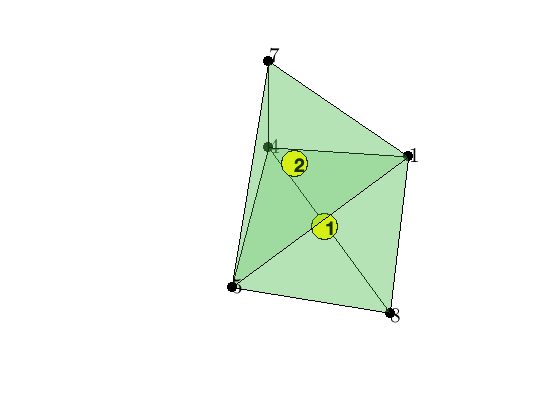

In [34]:
% A mesh with two tetrahedron with the ascend ordering
elem = [1 4 5 8; 1 4 5 7];
node = [1,0,0; 1,1,1; 1,-1,-1; 0,1,0; -2,-1,0; 1,1,-1; 0,1,1; 0,-1,-1];
NT = size(elem,1);
showmesh3(node,elem,[],'FaceAlpha',0.25);
findelem3(node,elem);
findnode3(node,elem(:));
display(elem);
% generate edge array
totalEdge = uint32([elem(:,[1 2]); elem(:,[1 3]); elem(:,[1 4]); ...
                    elem(:,[2 3]); elem(:,[2 4]); elem(:,[3 4])]);
sortedTotalEdge = sort(totalEdge,2);
[edge, ~, je] = unique(sortedTotalEdge,'rows');
display(edge);
% generate face array
totalFace = uint32([elem(:,[2 3 4]); elem(:,[1 4 3]); ...
                    elem(:,[1 2 4]); elem(:,[1 3 2])]);
sortedTotalFace = sort(totalFace,2);                
[face, i2, jf] = unique(sortedTotalFace,'rows');
display(face);
% generate pointers of indices
elem2edge = uint32(reshape(je,NT,6))
elem2face = uint32(reshape(jf,NT,4))
% find orientation of elem
[v,elemSign] = simplexvolume(node,elem)

Since we are using the ascend ordering, the inconsistency with the induced orientation is 
* `elem2faceSign = [1 -1 1 -1];`
* `face2edgeSign = [1 -1 1];`

## Boundary Faces and Boundary Conditions

We use `bdFlag` to record the boundary condition; see [Data Structure: Boundary Conditions](bddoc.html) for details. For short, `bdFlag` has the same size with `elem`, and records the boundary type of each local faces. If we change the ordering of `elem`, the corresponding local faces are changed. Threfore when we sort the `elem`, we should sort the `bdFlag` respectively. We use `sortelem3` to sort `elem` and `bdFlag` at the same time. Note that `sort(elem,2)` sorts the `elem` only, and leave
`bdFlag` unchanged.


elem =

     1     2     3     7
     1     4     3     7
     1     5     6     7
     1     5     8     7
     1     2     6     7
     1     4     8     7


bdFlag =

  6�4 uint8 matrix

   1   0   0   2
   2   0   0   2
   2   0   0   2
   2   0   0   2
   1   0   0   2
   2   0   0   2

change to ascend ordering

elem =

     1     2     3     7
     1     3     4     7
     1     5     6     7
     1     5     7     8
     1     2     6     7
     1     4     7     8


bdFlag =

  6�4 uint8 matrix

   1   0   0   2
   2   0   0   2
   2   0   0   2
   2   0   2   0
   1   0   0   2
   2   0   2   0



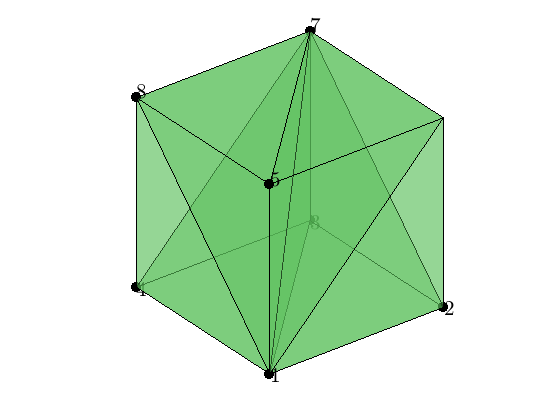

In [35]:
[node,elem] = cubemesh([-1,1,-1,1,-1,1],2);
bdFlag = setboundary3(node,elem,'Dirichlet','x==1','Neumann','x~=1');
figure(2); clf;
showmesh3(node,elem);
display(elem); display(bdFlag);
findnode3(node,[1,2,3,4,5,7,8]);
display('change to ascend ordering');
[elem,bdFlag] = sortelem3(elem,bdFlag)

We can use `bdFlag` to find the boundary nodes, edges and faces. To find the outwords normal direction of the boundary face, we use `gradbasis3` to get `Dlambda(t,:,k)` which is the gradient of $\lambda_k$. The outward normal direction of the kth face can be obtained by `-Dlambda(t,:,k)` which is independent of the ordering and orientation of `elem`.

In [36]:
Dlambda = gradbasis3(node,elem);
T = auxstructure3(elem);
elem2face = T.elem2face; 
face = T.face;
NF = size(face,1);
if ~isempty(bdFlag)
    % Find Dirchelt boundary faces and nodes
    isBdFace = false(NF,1);
    isBdFace(elem2face(bdFlag(:,1) == 1,1)) = true;
    isBdFace(elem2face(bdFlag(:,2) == 1,2)) = true;
    isBdFace(elem2face(bdFlag(:,3) == 1,3)) = true; 
    isBdFace(elem2face(bdFlag(:,4) == 1,4)) = true;
    DirichletFace = face(isBdFace,:);
    % Find outwards normal direction of Neumann boundary faces
    bdFaceOutDirec = zeros(NF,3);
    bdFaceOutDirec(elem2face(bdFlag(:,1) == 2,1),:) = -Dlambda(bdFlag(:,1) == 2,:,1);
    bdFaceOutDirec(elem2face(bdFlag(:,2) == 2,2),:) = -Dlambda(bdFlag(:,2) == 2,:,2);
    bdFaceOutDirec(elem2face(bdFlag(:,3) == 2,3),:) = -Dlambda(bdFlag(:,3) == 2,:,3);
    bdFaceOutDirec(elem2face(bdFlag(:,4) == 2,4),:) = -Dlambda(bdFlag(:,4) == 2,:,4);
end
% normalize the boundary face outwards direction
vl = sqrt(dot(bdFaceOutDirec,bdFaceOutDirec,2));
idx = (vl==0);
NeumannFace = face(~idx,:);
bdFaceOutDirec(idx,:) = [];
vl(idx) = [];
bdFaceOutDirec = bdFaceOutDirec./[vl vl vl];
display(DirichletFace);
display(NeumannFace);
display(bdFaceOutDirec);


DirichletFace =

  2�3 uint32 matrix

   2   3   7
   2   6   7


NeumannFace =

  10�3 uint32 matrix

   1   2   3
   1   2   6
   1   3   4
   1   4   8
   1   5   6
   1   5   8
   3   4   7
   4   7   8
   5   6   7
   5   7   8


bdFaceOutDirec =

     0     0    -1
     0    -1     0
     0     0    -1
    -1     0     0
     0    -1     0
    -1     0     0
     0     1     0
     0     1     0
     0     0     1
     0     0     1

